# Keras

In [1]:
cd /content/drive/My Drive/Tobigs

/content/drive/My Drive/Tobigs


In [2]:
ls

kaggle.json            test_df.csv           train_df.csv
radam_submission.csv   test_df.csv.zip       train_df.csv.zip
sample_submission.csv  torch_submission.csv


## Import Library

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [4]:
!pip install keras-rectified-adam

In [5]:
# data
import pandas as pd
import numpy as np

# model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras_radam.training import RAdamOptimizer
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


## Load Data

In [0]:
sample_submission = pd.read_csv("sample_submission.csv")
train = pd.read_csv("train_df.csv")
test = pd.read_csv("test_df.csv")

In [7]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
test.head()

,Unnamed: 0,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,57808,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4960,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,35755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15543,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,48968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values

In [0]:
X_test = test.iloc[:, 1:].values

## Preprocessing

In [0]:
## 전처리
X = X / 255.0
X_test = X_test / 255.0

In [0]:
## Reshape to 3 dimension
X = X.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [13]:
## Onehot Encoding
y = to_categorical(y)

print(f"Label size {y.shape}")

Label size (42000, 10)


In [0]:
# ctrl + space: 자동완성
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=2018)

In [15]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (37800, 10) (4200, 10)


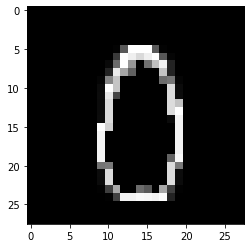

In [16]:
## 데이터 찍어보기
idx = 500
plt.imshow(X_train[idx].reshape(28, 28), cmap="gray")

## Modeling

In [0]:
## Hyperparameters
epochs = 100
batch_size = 512

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", 
                 input_shape=(28,28,1), kernel_initializer='he_normal'),
  tf.keras.layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu", 
                 kernel_initializer='he_normal'),
  
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu", 
                         kernel_initializer='he_normal'),
  tf.keras.layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu", 
                         kernel_initializer='he_normal'),

  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu", 
                         kernel_initializer='he_normal'),

  tf.keras.layers.MaxPool2D(pool_size=(2,2)),

  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation="relu", 
                        kernel_initializer='he_normal'),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="softmax", 
                        kernel_initializer='he_normal'),
])

In [0]:
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              # optimizer = RAdamOptimizer(),
              # onehot encoding이 안되어있으면 sparse_categorical_crossentropy
              metrics=["accuracy"])

In [20]:
model.summary()
# Total parameter를 통해 시간복잡도를 알 수 있음 (걸릴 시간 알 수 있음)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [0]:
## Data augmentation

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=batch_size)
test_gen = datagen.flow(X_val, y_val, batch_size=batch_size)

In [22]:
history = model.fit_generator(train_gen, 
                              epochs = epochs,
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              validation_data = test_gen,
                              validation_steps = X_val.shape[0] // batch_size)

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
73/73 [==============================] - 24s 327ms/step - loss: 0.3007 - accuracy: 0.9070 - val_loss: 0.4447 - val_accuracy: 0.8418
Epoch 2/100
73/73 [==============================] - 23s 316ms/step - loss: 0.0654 - accuracy: 0.9807 - val_loss: 0.5743 - val_accuracy: 0.7859
Epoch 3/100
73/73 [==============================] - 23s 318ms/step - loss: 0.0444 - accuracy: 0.9862 - val_loss: 0.1363 - val_accuracy: 0.9558
Epoch 4/100
73/73 [==============================] - 23s 317ms/step - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.1050 - val_accuracy: 0.9688
Epoch 5/100
73/73 [==============================] - 24s 329ms/step - loss: 0.0343 - accuracy: 0.9897 - val_loss: 0.0609 - val_accuracy: 0.9844
Epoch 6/100
73/73 [==============================] - 23s 319ms/step - loss: 0.0269 - accuracy: 0.9914 - val_loss: 0.0593 - val_accuracy: 0.9829
Epoch 7/100
73/73 [=======================

## Evaluation

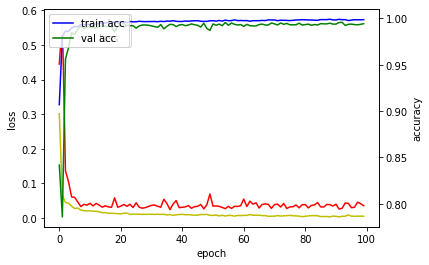

In [23]:
# keras history plot
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

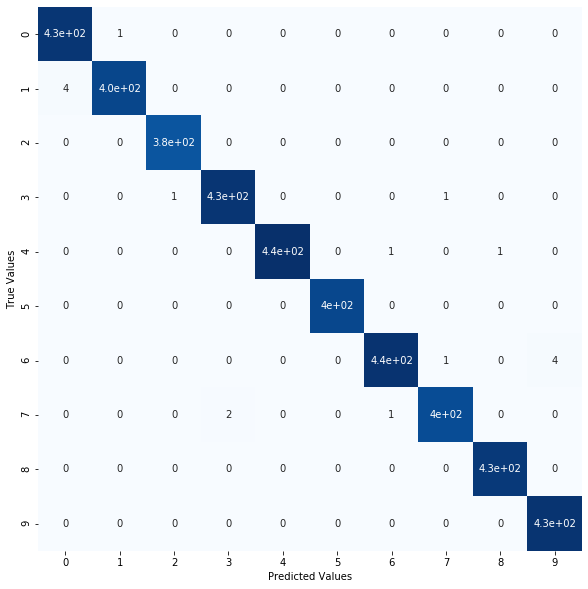

In [24]:
## Confusion Matrix

fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(X_val) # Predict encoded label as 2 => [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_val = np.argmax(y_val, 1) # Decode labels

mat = confusion_matrix(Y_val, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

## Submission

In [0]:
predictions = model.predict_classes(X_test)

In [26]:
predictions

array([8, 0, 5, ..., 3, 4, 1])

In [27]:
sample_submission["Category"] = pd.Series(predictions)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [0]:
sample_submission.to_csv("CNN_keras_sub.csv", index=False)

## Reference Kernel

https://www.kaggle.com/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1